# Cargue de Datos para el Modelo Autoencoders

In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [8]:
import pandas as pd
ruta = r'C:\Users\jthow\iCloudDrive\Documents\3_Maestria_Estadistica_UNINORTE\3_Tercer_Semestre\Machine_Learning\tornados.csv.zip'  
df = pd.read_csv(ruta)

## Autoencoders

In [16]:
df['loss'] = df['loss'].replace(0, pd.NA)
df['loss'] = df['loss'].interpolate(method='linear')
# Imputar los valores NaN con la media de la columna 'mag'
df['mag'] = df['mag'].fillna(df['mag'].mean())

644/644 [==============================] - 1s 1ms/step

📊 Comparación de Modelos:
                    Modelo   MAE  RMSE      R²  CPU time (s)
0         Regresión Lineal  1.71  9.03  0.3570        0.0646
1            Random Forest  1.22  8.60  0.4172      137.7482
2        Gradient Boosting  1.20  9.02  0.3586       20.0048
3  Autoencoder + Regresión  1.89  8.74  0.3977      394.0000


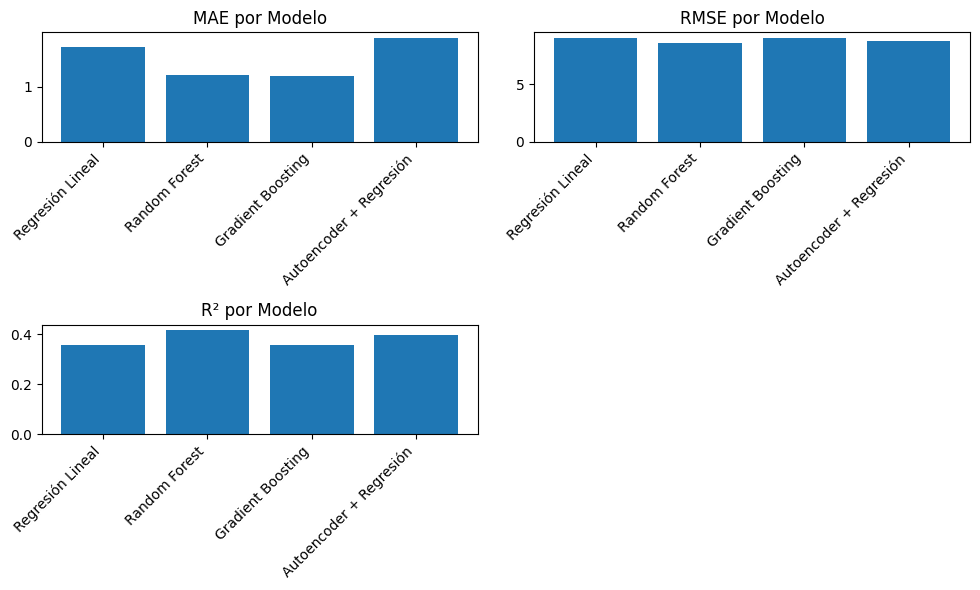

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import tensorflow as tf
from tensorflow.keras import layers, models
import time

# Preparación de datos
columns_to_drop = ['date', 'time', 'tz', 'datetime_utc', 'st', 'fc']
X = df.drop(columns=columns_to_drop + ['inj'])
y = df['inj']

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Función para evaluar modelo
def evaluar_modelo(y_true, y_pred, nombre_modelo, tiempo=None):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    resultado = {
        'Modelo': nombre_modelo,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R²': round(r2, 4)
    }
    
    if tiempo is not None:
        resultado['CPU time (s)'] = round(tiempo, 4)
    
    return resultado

# Lista para almacenar resultados
resultados = []

# 1. Modelo de Regresión Lineal
start_time = time.time()
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_tiempo = time.time() - start_time
resultados.append(evaluar_modelo(y_test, lr_pred, 'Regresión Lineal', lr_tiempo))

# 2. Random Forest
start_time = time.time()
rf_model = RandomForestRegressor(n_estimators=100, random_state=101)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_tiempo = time.time() - start_time
resultados.append(evaluar_modelo(y_test, rf_pred, 'Random Forest', rf_tiempo))

# 3. Gradient Boosting
start_time = time.time()
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=101)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
gb_tiempo = time.time() - start_time
resultados.append(evaluar_modelo(y_test, gb_pred, 'Gradient Boosting', gb_tiempo))

# 4. Modelo de Autoencoder
start_time = time.time()
# Codificador
n_input = X_train_scaled.shape[1]
n_encoded = 16  

input_layer = layers.Input(shape=(n_input,))
encoded = layers.Dense(n_encoded, activation='relu')(input_layer)
decoded = layers.Dense(n_input, activation='linear')(encoded)

autoencoder = models.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

encoder = models.Model(inputs=input_layer, outputs=encoded)
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

reg_model = models.Sequential([
    layers.Input(shape=(n_encoded,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
reg_model.compile(optimizer='adam', loss='mse')
reg_model.fit(X_train_encoded, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

y_pred = reg_model.predict(X_test_encoded).flatten()
autoencoder_tiempo = time.time() - start_time
resultados.append(evaluar_modelo(y_test, y_pred, 'Autoencoder + Regresión', autoencoder_tiempo))

# Crear DataFrame de resultados
resultados_df = pd.DataFrame(resultados)
print("\n📊 Comparación de Modelos:")
print(resultados_df)

# Visualizar comparación
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.bar(resultados_df['Modelo'], resultados_df['MAE'])
plt.title('MAE por Modelo')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 2)
plt.bar(resultados_df['Modelo'], resultados_df['RMSE'])
plt.title('RMSE por Modelo')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 3)
plt.bar(resultados_df['Modelo'], resultados_df['R²'])
plt.title('R² por Modelo')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models
import time

# 1. Preparar datos
# Identificar y manejar columnas de fecha
date_columns = ['date', 'datetime_utc']
for col in date_columns:
    if col in df.columns:
        # Convertir a timestamp
        df[col] = pd.to_datetime(df[col])
        # Extraer características de fecha
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        # Opcionalmente, eliminar columna original de fecha
        df = df.drop(columns=[col])

# Columnas a eliminar
columns_to_drop = ['time', 'tz', 'st', 'fc']
X = df.drop(columns=columns_to_drop + ['inj'])
y = df['inj']

# Verificar tipos de datos
print("Tipos de datos antes de escalar:")
print(X.dtypes)

# Manejar valores faltantes
X = X.select_dtypes(include=[np.number])  # Seleccionar solo columnas numéricas
print("\nColumnas numéricas:")
print(X.columns)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Construir Autoencoder
n_input = X_train_scaled.shape[1]
n_encoded = min(16, n_input // 2)  # Ajustar tamaño de capa codificada

# Tiempo de entrenamiento
start_time = time.time()

# Codificador
input_layer = layers.Input(shape=(n_input,))
encoded = layers.Dense(n_input // 2, activation='relu')(input_layer)
encoded = layers.Dense(n_encoded, activation='relu')(encoded)

# Decodificador
decoded = layers.Dense(n_input // 2, activation='relu')(encoded)
decoded = layers.Dense(n_input, activation='linear')(decoded)

# Autoencoder completo
autoencoder = models.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar autoencoder con early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

history = autoencoder.fit(
    X_train_scaled, 
    X_train_scaled, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping],
    verbose=1
)

# Codificador como extractor de características
encoder = models.Model(inputs=input_layer, outputs=encoded)

# 3. Usar representaciones comprimidas
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

# 4. Modelo de regresión usando la salida del encoder
reg_model = models.Sequential([
    layers.Input(shape=(n_encoded,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

reg_model.compile(optimizer='adam', loss='mse')

# Entrenar modelo de regresión con early stopping
early_stopping_reg = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

reg_model.fit(
    X_train_encoded, 
    y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping_reg],
    verbose=1
)

# Medir tiempo
training_time = round(time.time() - start_time, 4)

# 5. Evaluar
y_pred = reg_model.predict(X_test_encoded).flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 6. Mostrar resultados
print("\n📊 Evaluación del modelo:")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R²:", round(r2, 4))
print("⏱️ Tiempo CPU:", training_time, "segundos")

# DataFrame de resultados
resultados_autoencoder = pd.DataFrame({
    'Modelo': ['Autoencoder + Regresión'],
    'MAE': [round(mae, 2)],
    'RMSE': [round(rmse, 2)],
    'R²': [round(r2, 4)],
    'CPU time (s)': [training_time]
})

resultados_autoencoder

Tipos de datos antes de escalar:
om                      int64
yr                      int64
mo                      int64
dy                      int64
stf                     int64
mag                   float64
fat                     int64
loss                  float64
slat                  float64
slon                  float64
elat                  float64
elon                  float64
len                   float64
wid                     int64
ns                      int64
sn                      int64
f1                      int64
f2                      int64
f3                      int64
f4                      int64
date_year               int32
date_month              int32
date_day                int32
datetime_utc_year       int32
datetime_utc_month      int32
datetime_utc_day        int32
dtype: object

Columnas numéricas:
Index(['om', 'yr', 'mo', 'dy', 'stf', 'mag', 'fat', 'loss', 'slat', 'slon',
       'elat', 'elon', 'len', 'wid', 'ns', 'sn', 'f1', 'f2', 'f3', 'f4',
   

,Modelo,MAE,RMSE,R²,CPU time (s)
0,Autoencoder + Regresión,2.21,11.46,-0.0349,275.9538


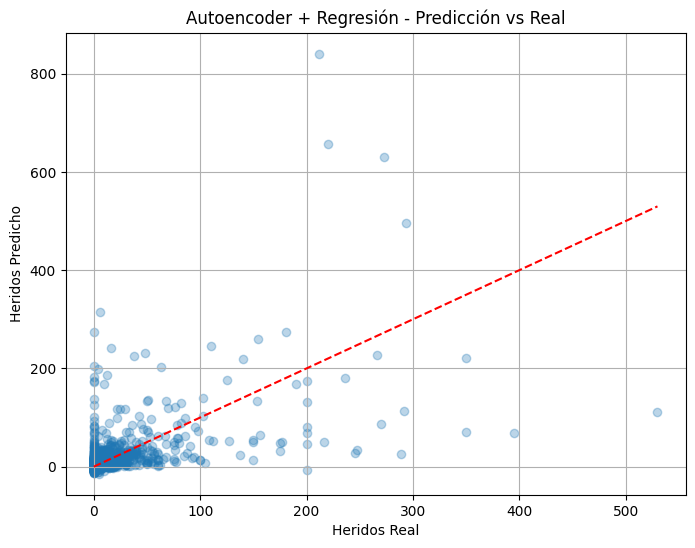

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Heridos Real")
plt.ylabel("Heridos Predicho")
plt.title("Autoencoder + Regresión - Predicción vs Real")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.grid(True)
plt.show()

La gráfica de dispersión muestra la comparación entre los valores reales de heridos por tornados (inj) y las predicciones realizadas por el modelo Autoencoder + Regresión. Cada punto azul representa un evento individual: el eje X indica la cantidad real de heridos, mientras que el eje Y indica el valor predicho por el modelo. La línea roja discontinua representa una predicción perfecta, es decir, donde el número de heridos predicho coincide exactamente con el valor real.

Aunque la mayoría de los puntos se agrupan cerca del origen, se observa una alta concentración de eventos con pocos heridos, lo cual es coherente con la distribución real de los datos. Sin embargo, también se puede ver que, para los casos con mayor número de heridos (eventos extremos), el modelo tiende a subestimar los valores reales. Esto sugiere que el modelo es bueno captando el comportamiento general, pero le cuesta ajustarse en los extremos.

En conjunto, el modelo logra una predicción razonable para la mayoría de los casos, pero aún tiene margen de mejora, especialmente para eventos con mayor número de heridos. Aun así, puede considerarse útil como una primera aproximación o en escenarios donde los errores extremos no sean críticos.